In [405]:
#import stuff we need
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import cv2
import os
import librosa
import librosa.display
from routines import *
import warnings
warnings.filterwarnings('ignore')

In [406]:
#used for video converting
def pil_list_to_cv2(pil_list):
	#converts a list of pil images to a list of cv2 images
	png_list=[]
	for pil_img in pil_list:
		pil_img.save('trash_image.png',format='png')
		png_list.append(cv2.imread('trash_image.png'))
	os.remove('trash_image.png')
	return png_list
#generate an .avi video
def generate_video(cv2_list,path='car_race.avi',fps=10): 
	#makes a video from a given cv2 image list
	if len(cv2_list)==0:
		raise ValueError('the given png list is empty!')
	video_name = path
	frame=cv2_list[0] 
	# setting the frame width, height width 
	# the width, height of first image 
	height, width, layers = frame.shape   
	video = cv2.VideoWriter(video_name, 0, fps, (width, height))  
	# Appending the images to the video one by one 
	for cv2_image in cv2_list:  
	    video.write(cv2_image) 
	# Deallocating memories taken for window creation 
	cv2.destroyAllWindows()  
	video.release()  # releasing the video generated 

In [407]:
def get_theta_dd(theta,l,g):
	return -g/l*np.sin(theta)

def calculate_trajectory(theta_init,theta_d_init,n_iter=1000,dt=0.01,g=10,l=1,midpoint=True):
	print(dt)
	phase_traject=np.zeros((n_iter,2))#phase-space trajectory
	phase_traject[0,:]=np.array([theta_init,theta_d_init])
	if midpoint:
		print('calculating trajectory using explicite midpoint method...')
	else:
		print('calculating trajectory using explicite Euler method...')
	for i in range(n_iter-1):
		# theta_dd=-g/l*np.sin(phase_traject[i,0])
		theta_dd=get_theta_dd(phase_traject[i,0],l,g)

		if not midpoint:
		#explicite Euler
			phase_traject[i+1,1]=phase_traject[i,1]+dt*theta_dd
			phase_traject[i+1,0]=phase_traject[i,0]+dt*phase_traject[i+1,1]
		else:
		#explicite midpoint method
			theta_d1=phase_traject[i,1]+dt/2*theta_dd
			theta1=phase_traject[i,0]+dt/2*theta_d1
			theta_dd1=get_theta_dd(theta1,l,g)
			phase_traject[i+1,1]=phase_traject[i,1]+dt*theta_dd1
			phase_traject[i+1,0]=phase_traject[i,0]+dt/2*(phase_traject[i+1,1]+phase_traject[i,1])
	return phase_traject


def get_energy(theta,theta_d,m=1,l=1,g=10):
	y=l*np.cos(theta)
	e_pot=-m*g*y
	e_kin=m/2*(l*theta_d)**2
	return e_pot,e_kin

In [408]:
def render_phase_traject(phase_traject,img_res=1,m=1,l=1,g=10,save_path='trash_figures/pendulum_render',take_frame_every=1,progression=False):
	frames=[]
	e_pot=[]#the potential energy of each of the masses: e_pot=-m*g*y
	e_kin=[]#the kinetic energy of each of the masses: e_kin=m*l**2*theta_d**2/2
	h=int(img_res*200)
	w=h
	x0=int(h/2)
	y0=int(h/2)
	h_red=int(0.4*h)
	L=h_red
	d=int(0.02*h)
	d_4=d/4
	e_pot_0,e_kin_0=get_energy(phase_traject[0,0],phase_traject[0,1],m,l,g)
	energy=e_pot_0+e_kin_0
	print('initial energy: '+str(energy))
	prev_points=[]
	prev_phase=[]
	max_points=500
	# max_theta_d=1.2*np.max(np.abs(phase_traject[:,1]))
	max_theta_d=10
	for i in range(phase_traject.shape[0]):
		if progression:
			take_frame_every=1+int(i/100)       
		if i%take_frame_every==0:
			theta=phase_traject[i,0]
			theta_d=phase_traject[i,1]
			prev_phase.append((theta,theta_d))
			#----transform to cartesian coordinates---
			x=x0+L*np.sin(theta)
			y=y0+L*np.cos(theta)
			prev_points.append(np.array([x,y]))
			#---draw the image ----
			img = Image.new("RGB", (w, h), "white")
			draw = ImageDraw.Draw(img)
			n_prev=min(max_points,len(prev_points))
			for k in range(n_prev-1):
				idx=n_prev-k
				point=prev_points[-idx]
				x=point[0]
				y=point[1]
				point=prev_points[-idx+1]
				xx=point[0]
				yy=point[1]
				intensity=int(255*(1-0.99**idx))
				draw.line([(x,y),(xx,yy)],fill=(intensity,intensity,255),width=2)
			draw.line([(x0,y0),(x,y)],fill=(0,0,0),width=1)
			draw.ellipse([(x-d,y-d),(x+d,y+d)], fill=(0,0,0), outline=None)
			frames.append(img)

			#----calculate the energies----
			e_pot_i,e_kin_i=get_energy(theta,theta_d,m,l,g)
			e_pot.append(e_pot_i)
			e_kin.append(e_kin_i)

	cv2_list=pil_list_to_cv2(frames)
	generate_video(cv2_list,path=save_path+'.avi',fps=1000/40)

	e_pot=np.asarray(e_pot)
	e_kin=np.asarray(e_kin)
	print('final energy: '+str(e_pot[-1]+e_kin[-1]))
	return e_pot,e_kin

In [409]:

def get_spectrogram(phase_traject,subsampling_fac=20,hop_size=10,N=256):
    if (int(np.log2(N))-np.log2(N))!=0:
        raise ValueError('the sfft size N must be a power of two!')
    samples=np.sin(phase_traject[0::subsampling_fac,0])
    samples_to_render=samples
    STFT=classic_STFT(ns=hop_size,N=N)
    spec=STFT.get_energy_spec(samples_to_render)
    return spec


def render_traject_to_wave(phase_traject,img_res=1,m=1,l=1,g=10,save_path='trash_figures/',take_frame_every=1,with_spec=False,speed=1,progression=False):
	if with_spec:
		spec=get_spectrogram(phase_traject,subsampling_fac=take_frame_every,hop_size=1,N=256)
		spec=np.log(spec-np.min(spec)+10)
		spec-=np.min(spec)
		spec/=np.max(spec)
	frames=[]
	h=int(img_res*200)
	w=2*h
	x0=int(h/2)
	y0=int(h/2)
	h_red=int(0.4*h)
	L=h_red
	d=int(0.02*h)
	d_4=d/4
	prev_points=[]
	speed*=img_res
	h_spec=1
	if progression:
		init_frame_every=take_frame_every
	frame_counter=1
	for i in range(phase_traject.shape[0]):
		if progression:
			take_frame_every=init_frame_every+int(frame_counter/10)
		if i%10000==0:
			print('rendering iteration: '+str(i)+'/'+str(phase_traject.shape[0])) 
		if i%take_frame_every==0:
			frame_counter+=1
			theta=phase_traject[i,0]
			theta_d=phase_traject[i,1]
			#----transform to cartesian coordinates---
			x1=x0+L*np.sin(theta)
			y1=y0+L*np.cos(theta)
			prev_points.append(np.array([x1,y1]))
			#---draw the image ----
			if with_spec:
				h_fac=1.5
				img=Image.new("RGB", (w, int(h_fac*h)), "white")
			else:
				img = Image.new("RGB", (w, h), "white")
			draw = ImageDraw.Draw(img)
			l=len(prev_points)
			for k in range(l-1):
				point=prev_points[k+1]
				x=point[0]
				y=y0+L+int(speed*(l-(k+1)))
				point=prev_points[k]
				xx=point[0]
				yy=y0+L+int(speed*(l-k))
				draw.line([(y,x),(yy,xx)],fill=(0,0,255),width=2)
				if with_spec:
					for j in range(min(int((h_fac-1)*0.95*h/(h_spec*img_res)),int(0.75*spec.shape[0]))):
						c=int(spec[j,k]*255)
						for step in range(yy-y):
							draw.line([(y+step,int(0.95*h_fac*h-h_spec*img_res*j)),(y+step,int(0.95*h_fac*h-h_spec*img_res*(j+1)))], fill=(c,c,c))
			draw.line([(y1,x1),(y0+L,x1)],fill=(150,150,150),width=1)#pointer to wave 
			draw.line([(y0,x0),(y1,x1)],fill=(0,0,0),width=1)#arm
			draw.ellipse([(y1-d,x1-d),(y1+d,x1+d)], fill=(0,0,0), outline=None)
			frames.append(img)
	cv2_list=pil_list_to_cv2(frames)
	generate_video(cv2_list,path=save_path+'.avi',fps=1000/40)
	print('done!')

In [108]:
def fade_samples(samples):
    n_fade=20
    for i in range(n_fade):
        samples[i]=i/n_fade*samples[i]
        samples[-i-1]=i/n_fade*samples[-i-1]
    return samples

In [255]:
theta_init=1*np.pi/8
theta_d_init=0
dt=0.005
n_iter=1000000
phase_traject=calculate_trajectory(theta_init,theta_d_init,n_iter=n_iter,dt=dt)

0.005
calculating trajectory using explicite midpoint method...


initial energy: -9.238795325112868
final energy: -9.238806749150035


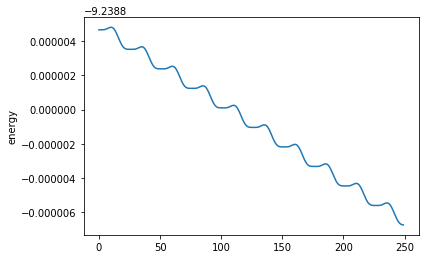

In [263]:
take_frame_every=8
progression=False
e_pot,e_kin=render_phase_traject(phase_traject[:2000],img_res=2,take_frame_every=take_frame_every,save_path='trash_figures/pendulum_render_normal'+str(theta_init)[:4],progression=progression)
plt.plot(e_pot+e_kin)
plt.ylabel('energy')
plt.show()

In [247]:
#make wave video
take_frame_every=15
speed=1
render_traject_to_wave(phase_traject[:5000],img_res=2,m=1,l=1,g=10,save_path='trash_figures/pendulum_wave'+str(theta_init)[:4],take_frame_every=take_frame_every,with_spec=True,speed=speed)

progress:1/335
progress:2/335
progress:3/335
progress:4/335
progress:5/335
progress:6/335
progress:7/335
progress:8/335
progress:9/335
progress:10/335
progress:11/335
progress:12/335
progress:13/335
progress:14/335
progress:15/335
progress:16/335
progress:17/335
progress:18/335
progress:19/335
progress:20/335
progress:21/335
progress:22/335
progress:23/335
progress:24/335
progress:25/335
progress:26/335
progress:27/335
progress:28/335
progress:29/335
progress:30/335
progress:31/335
progress:32/335
progress:33/335
progress:34/335
progress:35/335
progress:36/335
progress:37/335
progress:38/335
progress:39/335
progress:40/335
progress:41/335
progress:42/335
progress:43/335
progress:44/335
progress:45/335
progress:46/335
progress:47/335
progress:48/335
progress:49/335
progress:50/335
progress:51/335
progress:52/335
progress:53/335
progress:54/335
progress:55/335
progress:56/335
progress:57/335
progress:58/335
progress:59/335
progress:60/335
progress:61/335
progress:62/335
progress:63/335
p

evaluate the energy trajectory...


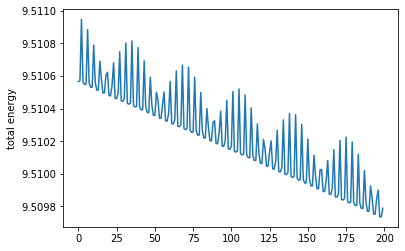

In [58]:
#plot the energy of the trajectory
total_energy=[]
print('evaluate the energy trajectory...')
calculate_every=100
for i in range(phase_traject.shape[0]):
	if i%calculate_every==0:
		e_pot,e_kin=get_energy(phase_traject[i,0],phase_traject[i,1])
		total_energy.append(e_pot+e_kin)	
plt.plot(total_energy)
plt.ylabel('total energy')
plt.show()

In [248]:
# transform the phase trajectory into sound
samples=np.sin(phase_traject[0::20,0])
samples_to_render=samples[:250000]
samples_to_render=fade_samples(samples_to_render)
print(samples_to_render.shape)

fs=6000
librosa.output.write_wav('trash_figures/singlependulum_sound_'+str(theta_init)[:4]+'.mp3', samples_to_render, fs,norm=True)
print('done!')

(50000,)
done!


In [ ]:
#show spec
time_step=0.05#ms
ns=time_step*fs
STFT=classic_STFT(ns=ns,N=256)
spec=STFT.get_energy_spec(samples_to_render)
plt.imshow(np.log(spec+1),origin='lower')
plt.show()

In [262]:
progression=True
speed=1
take_frame_every=8
render_traject_to_wave(phase_traject[:10000],img_res=2,m=1,l=1,g=10,save_path='trash_figures/pendulum_wave_progression',take_frame_every=take_frame_every,with_spec=False,speed=speed,progression=progression)

rendering iteration: 0/10000
done!


In [401]:
def render_multiple_traject_to_wave(phase_traject_list,l_list,color_list,m=1,img_res=1,g=10,save_path='trash_figures/',take_frame_every=1,with_spec=False,speed=1,progression=False):
	n_seq=int(phase_traject_list[0].shape[0]/(4+len(phase_traject_list)))
	spec_list=[]
	if with_spec:
		ptl_array=np.sin(np.asarray(phase_traject_list))
		for i in range(len(phase_traject_list)):
			phase_traject=np.arcsin(np.mean(ptl_array[:i+1],axis=0))
			spec=get_spectrogram(phase_traject,subsampling_fac=take_frame_every,hop_size=1,N=256)
			spec=np.log(spec-np.min(spec)+1)
			spec-=np.min(spec)
			spec/=np.max(spec)
			spec_list.append(2*spec)
	frames=[]
	h=int(img_res*200)
	w=2*h
	x0=int(h/2)
	y0=int(h/2)
	h_red=int(0.4*h)
	L=h_red*np.asarray(l_list)
	L_max=np.max(L)
	d=int(0.02*h)
	d_4=d/4
	prev_points=[]
	for i in range(len(phase_traject_list)):
		prev_points.append([])
	speed*=img_res
	h_spec=1
	if progression:
		init_frame_every=take_frame_every
	frame_counter=1
	for i in range(phase_traject_list[0].shape[0]):
		if progression:
			take_frame_every=init_frame_every+int(frame_counter/10)
		if i%take_frame_every==0:
			#---draw the image ----
			if with_spec:
				h_fac=1.5
				img=Image.new("RGB", (w, int(h_fac*h)), "white")
			else:
				img = Image.new("RGB", (w, h), "white")
			draw = ImageDraw.Draw(img)
			frame_counter+=1
			n_pt=min(int((i+1)/n_seq)+1,len(phase_traject_list))
			for pt,phase_traject in enumerate(phase_traject_list[:n_pt]):
				theta=phase_traject[i,0]
				theta_d=phase_traject[i,1]
                #----transform to cartesian coordinates---
				x1=x0+L[pt]*np.sin(theta)
				y1=y0+L[pt]*np.cos(theta)
				prev_points[pt].append(np.array([x1,y1]))
				l=len(prev_points[pt])
				for k in range(l-1):
					point=prev_points[pt][k+1]
					x=point[0]
					y=y0+L_max+int(speed*(l-(k+1)))
					point=prev_points[pt][k]
					xx=point[0]
					yy=y0+L_max+int(speed*(l-k))
					draw.line([(y,x),(yy,xx)],fill=color_list[pt],width=2)
					if with_spec:
						for j in range(min(int((h_fac-1)*0.95*h/(h_spec*img_res)),int(0.75*spec.shape[0]))):
							c=int(min(spec_list[n_pt-1][j,k],1)*255)
							for step in range(int(yy-y)):
								draw.line([(y+step,int(0.95*h_fac*h-h_spec*img_res*j)),(y+step,int(0.95*h_fac*h-h_spec*img_res*(j+1)))], fill=(c,c,c))
				draw.line([(y1,x1),(y0+L_max,x1)],fill=(150,150,150),width=1)#pointer to wave 
				draw.line([(y0,x0),(y1,x1)],fill=(0,0,0),width=1)#arm
				draw.ellipse([(y1-d,x1-d),(y1+d,x1+d)], fill=color_list[pt], outline=None)
			frames.append(img)
	cv2_list=pil_list_to_cv2(frames)
	generate_video(cv2_list,path=save_path+'.avi',fps=1000/40)
	print('done!')

In [385]:
tot_ptl=[]
#T_2=2/3T_1 -> l_2=(2/3)^2l_1
l_list=[1,(4/5)**2,(2/3)**2,(2/4)**2,(2/8)**2]
#l_list=[1,(2/3)**2,(2/4)**2,(2/5)**2,(2/6)**2,(2/8)**2]
#l_list=[1,(2/3)**2,(2/4)**2,]
for i in range(len(l_list)):
    tot_ptl.append(calculate_trajectory(np.pi/8,0,l=l_list[i],n_iter=700000,dt=0.005))

0.005
calculating trajectory using explicite midpoint method...
0.005
calculating trajectory using explicite midpoint method...
0.005
calculating trajectory using explicite midpoint method...
0.005
calculating trajectory using explicite midpoint method...
0.005
calculating trajectory using explicite midpoint method...


In [403]:
color_list=[(255,0,0),(0,255,0),(0,0,255),(255,0,255),(0,255,255),(255,255,255)]
phase_traject_list=[]
for i in range(len(tot_ptl)):
    phase_traject_list.append(tot_ptl[i][:3000])
with_spec=True
print('render mutliple waves')
render_multiple_traject_to_wave(phase_traject_list,l_list,color_list,m=1,img_res=2,g=10,save_path='trash_figures/multi_wave',take_frame_every=8,with_spec=with_spec,speed=1,progression=False)

render mutliple waves
progress:1/376
progress:2/376
progress:3/376
progress:4/376
progress:5/376
progress:6/376
progress:7/376
progress:8/376
progress:9/376
progress:10/376
progress:11/376
progress:12/376
progress:13/376
progress:14/376
progress:15/376
progress:16/376
progress:17/376
progress:18/376
progress:19/376
progress:20/376
progress:21/376
progress:22/376
progress:23/376
progress:24/376
progress:25/376
progress:26/376
progress:27/376
progress:28/376
progress:29/376
progress:30/376
progress:31/376
progress:32/376
progress:33/376
progress:34/376
progress:35/376
progress:36/376
progress:37/376
progress:38/376
progress:39/376
progress:40/376
progress:41/376
progress:42/376
progress:43/376
progress:44/376
progress:45/376
progress:46/376
progress:47/376
progress:48/376
progress:49/376
progress:50/376
progress:51/376
progress:52/376
progress:53/376
progress:54/376
progress:55/376
progress:56/376
progress:57/376
progress:58/376
progress:59/376
progress:60/376
progress:61/376
progress:62

progress:143/376
progress:144/376
progress:145/376
progress:146/376
progress:147/376
progress:148/376
progress:149/376
progress:150/376
progress:151/376
progress:152/376
progress:153/376
progress:154/376
progress:155/376
progress:156/376
progress:157/376
progress:158/376
progress:159/376
progress:160/376
progress:161/376
progress:162/376
progress:163/376
progress:164/376
progress:165/376
progress:166/376
progress:167/376
progress:168/376
progress:169/376
progress:170/376
progress:171/376
progress:172/376
progress:173/376
progress:174/376
progress:175/376
progress:176/376
progress:177/376
progress:178/376
progress:179/376
progress:180/376
progress:181/376
progress:182/376
progress:183/376
progress:184/376
progress:185/376
progress:186/376
progress:187/376
progress:188/376
progress:189/376
progress:190/376
progress:191/376
progress:192/376
progress:193/376
progress:194/376
progress:195/376
progress:196/376
progress:197/376
progress:198/376
progress:199/376
progress:200/376
progress:201/3

progress:273/376
progress:274/376
progress:275/376
progress:276/376
progress:277/376
progress:278/376
progress:279/376
progress:280/376
progress:281/376
progress:282/376
progress:283/376
progress:284/376
progress:285/376
progress:286/376
progress:287/376
progress:288/376
progress:289/376
progress:290/376
progress:291/376
progress:292/376
progress:293/376
progress:294/376
progress:295/376
progress:296/376
progress:297/376
progress:298/376
progress:299/376
progress:300/376
progress:301/376
progress:302/376
progress:303/376
progress:304/376
progress:305/376
progress:306/376
progress:307/376
progress:308/376
progress:309/376
progress:310/376
progress:311/376
progress:312/376
progress:313/376
progress:314/376
progress:315/376
progress:316/376
progress:317/376
progress:318/376
progress:319/376
progress:320/376
progress:321/376
progress:322/376
progress:323/376
progress:324/376
progress:325/376
progress:326/376
progress:327/376
progress:328/376
progress:329/376
progress:330/376
progress:331/3

progress:28/376
progress:29/376
progress:30/376
progress:31/376
progress:32/376
progress:33/376
progress:34/376
progress:35/376
progress:36/376
progress:37/376
progress:38/376
progress:39/376
progress:40/376
progress:41/376
progress:42/376
progress:43/376
progress:44/376
progress:45/376
progress:46/376
progress:47/376
progress:48/376
progress:49/376
progress:50/376
progress:51/376
progress:52/376
progress:53/376
progress:54/376
progress:55/376
progress:56/376
progress:57/376
progress:58/376
progress:59/376
progress:60/376
progress:61/376
progress:62/376
progress:63/376
progress:64/376
progress:65/376
progress:66/376
progress:67/376
progress:68/376
progress:69/376
progress:70/376
progress:71/376
progress:72/376
progress:73/376
progress:74/376
progress:75/376
progress:76/376
progress:77/376
progress:78/376
progress:79/376
progress:80/376
progress:81/376
progress:82/376
progress:83/376
progress:84/376
progress:85/376
progress:86/376
progress:87/376
progress:88/376
progress:89/376
progress

In [404]:
# transform the phase trajectory into sound
#n_seq=int(phase_traject_list[0].shape[0]/len(phase_traject_list))
spec_list=[]
fs=6000
if with_spec:
	ptl_array=np.sin(np.asarray(tot_ptl))
	for i in range(len(tot_ptl)):
		phase_traject=np.mean(ptl_array[:i+1],axis=0)
		samples=np.asarray(phase_traject)[::20]
		samples_to_render=samples[:20000]
		samples_to_render=np.asfortranarray(fade_samples(samples_to_render))
		print(samples_to_render.shape)
		librosa.output.write_wav('trash_figures/multipendulum_sound'+'_'+str(i)+'.mp3', samples_to_render, fs,norm=True)
print('done!')

(20000, 2)
(20000, 2)
(20000, 2)
(20000, 2)
(20000, 2)
done!
